# Nested cross-validation

Neste bloco de notas, mostramos um padrão chamado `nested cross-validation` que deve ser usado quando você deseja avaliar um modelo e ajustar os hiperparâmetros do modelo.

A validação cruzada é uma ferramenta poderosa para avaliar o desempenho de generalização de um modelo. Também é usado para selecionar o melhor modelo de um conjunto de modelos. Este conjunto de modelos pode ser a mesma família de preditor, mas com parâmetros diferentes. Nesse caso, chamamos esse procedimento de `hyperparameter tuning.`

Também podemos imaginar que gostaríamos de escolher entre modelos heterogêneos que usarão de forma semelhante a validação cruzada.

Antes de entrarmos em detalhes sobre a validação cruzada aninhada, primeiro vamos relembrar o padrão usado para ajustar os hiperparâmetros de um modelo.

Vamos carregar o conjunto de dados do câncer de mama.

In [1]:
from sklearn.datasets import load_breast_cancer

data, target = load_breast_cancer(return_X_y=True)

Agora, faremos um exemplo mínimo usando o utilitário `GridSearchCV` para encontrar os melhores parâmetros por meio de validação cruzada.

In [2]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

param_grid = {"C": [0.1, 1, 10], "gamma": [.01, .1]}
model_to_tune = SVC()

search = GridSearchCV(estimator=model_to_tune, param_grid=param_grid,
                      n_jobs=2)
search.fit(data, target)

GridSearchCV(estimator=SVC(), n_jobs=2,
             param_grid={'C': [0.1, 1, 10], 'gamma': [0.01, 0.1]})

Lembramos que `GridSearchCV` vamos treinar um modelo com algum parâmetro específico em um conjunto de treinamento e avaliá-lo em testes. No entanto, essa avaliação é feita por meio de validação cruzada usando o cvparâmetro. Este procedimento é repetido para todas as combinações possíveis de parâmetros dados em `param_grid`.

O atributo `best_params_` nos dará o melhor conjunto de parâmetros que maximizam a pontuação média nos conjuntos de testes internos.

In [3]:
print(f"The best parameter found are: {search.best_params_}")

The best parameter found are: {'C': 0.1, 'gamma': 0.01}


Podemos agora mostrar a pontuação média obtida usando o parâmetro `best_score_`.

In [5]:
print(f"The mean score in CV is: {search.best_score_:.3f}")

The mean score in CV is: 0.627


Nesta fase, deve-se ter muito cuidado ao usar essa partitura. A interpretação incorreta seria a seguinte: como a pontuação foi calculada em um conjunto de teste, ela poderia ser considerada a pontuação de teste do nosso modelo.

No entanto, não devemos esquecer que usamos essa pontuação para escolher o melhor modelo. Isso significa que usamos o conhecimento do conjunto de testes (ou seja, pontuação do teste) para decidir o parâmetro de treinamento do nosso modelo.

Portanto, essa pontuação não é uma estimativa razoável de nosso erro de teste. Na verdade, podemos mostrar que será muito otimista na prática. A boa maneira é usar uma validação cruzada "aninhada". Usaremos uma validação cruzada interna correspondente ao procedimento anterior mostrado para otimizar os hiperparâmetros. Também incluiremos esse procedimento em uma validação cruzada externa, que será usada para estimar o erro de teste de nosso modelo ajustado.

Nesse caso, nossa validação cruzada interna sempre obterá o conjunto de treinamento da validação cruzada externa, tornando possível calcular a pontuação do teste em um conjunto completamente independente.

Mostraremos a seguir como podemos criar essa validação cruzada aninhada e obter a pontuação do teste.

In [6]:
from sklearn.model_selection import cross_val_score, KFold

# Declare the inner and outer cross-validation
inner_cv = KFold(n_splits=4, shuffle=True, random_state=0)
outer_cv = KFold(n_splits=4, shuffle=True, random_state=0)

# Inner cross-validation for parameter search
model = GridSearchCV(
    estimator=model_to_tune, param_grid=param_grid, cv=inner_cv, n_jobs=2)

# Outer cross-validation to compute the testing score
test_score = cross_val_score(model, data, target, cv=outer_cv, n_jobs=2)
print(f"The mean score using nested cross-validation is: "
      f"{test_score.mean():.3f} +/- {test_score.std():.3f}")

The mean score using nested cross-validation is: 0.627 +/- 0.021


No exemplo acima, a pontuação relatada é mais confiável e deve estar próxima do desempenho de generalização esperado da produção.

Ilustraremos a diferença entre as pontuações da validação cruzada aninhada e não aninhada para mostrar que a última será muito otimista na prática. A este respeito, iremos repetir várias vezes a experiência e embaralhar os dados de forma diferente. Além disso, iremos armazenar a pontuação obtida com e sem a validação cruzada aninhada.

In [7]:
test_score_not_nested = []
test_score_nested = []

N_TRIALS = 20
for i in range(N_TRIALS):
    inner_cv = KFold(n_splits=4, shuffle=True, random_state=i)
    outer_cv = KFold(n_splits=4, shuffle=True, random_state=i)

    # Non_nested parameter search and scoring
    model = GridSearchCV(estimator=model_to_tune, param_grid=param_grid,
                         cv=inner_cv, n_jobs=2)
    model.fit(data, target)
    test_score_not_nested.append(model.best_score_)

    # Nested CV with parameter optimization
    test_score = cross_val_score(model, data, target, cv=outer_cv, n_jobs=2)
    test_score_nested.append(test_score.mean())

Podemos mesclar os dados e fazer um  box plot das duas estratégias.

In [8]:
import pandas as pd

all_scores = {
    "Not nested CV": test_score_not_nested,
    "Nested CV": test_score_nested,
}
all_scores = pd.DataFrame(all_scores)

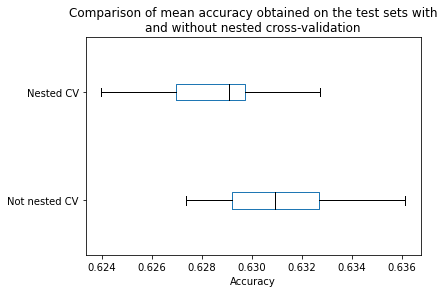

In [9]:
import matplotlib.pyplot as plt

color = {"whiskers": "black", "medians": "black", "caps": "black"}
all_scores.plot.box(color=color, vert=False)
plt.xlabel("Accuracy")
_ = plt.title("Comparison of mean accuracy obtained on the test sets with\n"
              "and without nested cross-validation")

Observamos que o desempenho de generalização do modelo com a validação cruzada aninhada não é tão bom quanto a validação cruzada não aninhada.

Como conclusão, ao otimizar partes do pipeline de aprendizado de máquina (por exemplo, hiperparâmetro, transformação, etc.), é necessário usar validação cruzada aninhada para avaliar o desempenho de generalização do modelo preditivo. Caso contrário, os resultados obtidos sem validação cruzada aninhada são otimistas demais.